In [167]:
#Importações
import pandas as pd
import numpy as np
import pycaret.classification as pc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score
import matplotlib.pyplot as plt

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

import os






Configuração MLFOW

In [168]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlflow.db")

experiment_name = 'ProjetoKobe '
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

Analise exploratoria

Preparação dos dados

In [169]:

#MLflow
with mlflow.start_run(experiment_id=experiment_id, run_name='PreparacaoDados'):
   
    percentual_treino = 0.8
    
  
    df_dev = pd.read_parquet("../data/raw/dataset_kobe_dev.parquet")
    
    # Colunas selecionadas
    colunas_selecionadas = ['lat','lon','minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']

    # Carregar o DataFrame a partir do arquivo parquet
    df_dev = pd.read_parquet("../data/raw/dataset_kobe_dev.parquet")

    # Remover todas as colunas que não estão na lista 'colunas_selecionadas'
    colunas_para_remover = [coluna for coluna in df_dev.columns if coluna not in colunas_selecionadas]
    df_dev.drop(columns=colunas_para_remover, inplace=True)
    df_dev = df_dev.dropna()

    df_dev.to_parquet('../data/processed/data_filtered.parquet', index=False)
    df_dev['shot_made_flag'] = df_dev['shot_made_flag'].astype(int)
    xtrain, xtest, ytrain, ytest =  train_test_split(df_dev[['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']],
                                                     df_dev['shot_made_flag'],
                                                     test_size= percentual_treino,
                                                     stratify=df_dev['shot_made_flag']
                                                   )
   
    xtrain['shot_made_flag'] = ytrain
    ytrain['shot_made_flag'] = ytest
   
    xtrain.to_parquet("../data/processed/base_train.parque")
    xtest.to_parquet("../data/processed/base_test.parque")   
   
     # Registre os parâmetros e métricas no MLflow
    mlflow.log_param('percentual_test', 1 - percentual_treino)
    mlflow.log_param('colunas_selecionadas', colunas_selecionadas)
    mlflow.log_metric('qtd_linhas_treino', xtrain.shape[0])
    mlflow.log_metric('qtd_linhas_test', xtest.shape[0])

In [170]:
mlflow.end_run()

Treinamento

,Description,Value
0,Session id,1692
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(4057, 7)"
6,Transformed test set shape,"(16228, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5827,0.5000,0.4992,0.5725,0.5332,0.1591,0.1604,0.2390
dt,Decision Tree Classifier,0.5292,0.5012,0.5632,0.5061,0.5328,0.0610,0.0615,0.0210


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5751,0.5960,0.4855,0.5637,0.5217,0.1432,0.1445


Log Loss: 5.5157751250260425


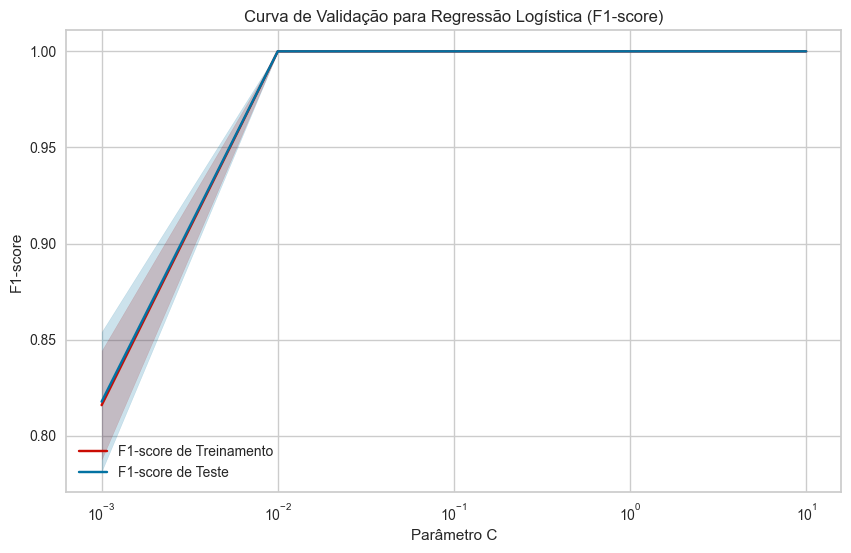

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5314,0.5176,0.5630,0.5083,0.5342,0.0653,0.0656


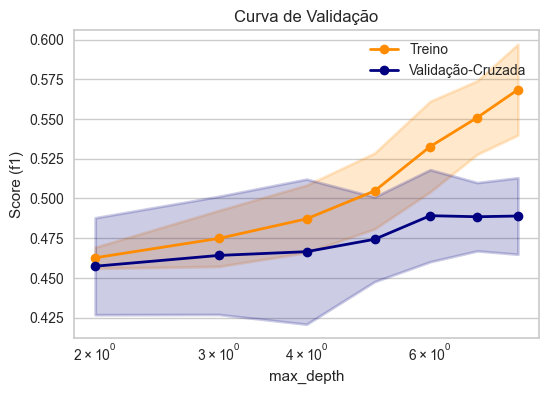

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6059,0.5000,0.4021,0.6393,0.4937,0.1976,0.2119
1,0.6084,0.5056,0.4072,0.6423,0.4984,0.2028,0.2170
2,0.5591,0.5000,0.5052,0.5414,0.5227,0.1140,0.1142
3,0.5419,0.5002,0.3093,0.5357,0.3922,0.0652,0.0715
4,0.5813,0.5000,0.4381,0.5822,0.5000,0.1520,0.1566
5,0.5567,0.4955,0.3402,0.5593,0.4231,0.0965,0.1044
6,0.6133,0.5107,0.3763,0.6697,0.4818,0.2104,0.2327
7,0.5556,0.5000,0.4508,0.5404,0.4915,0.1025,0.1038
8,0.5481,0.5000,0.3886,0.5357,0.4505,0.0830,0.0861


Fitting 10 folds for each of 4 candidates, totalling 40 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5314,0.5176,0.5630,0.5083,0.5342,0.0653,0.0656


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
Melhor modelo: 1


Registered model 'kobe' already exists. Creating a new version of this model...
Created version '22' of model 'kobe'.


In [171]:
registered_model_name = 'kobe'
nexamples = 5
model_version = -1
#MLflow
with mlflow.start_run(experiment_id=experiment_id, run_name='Treinamento'):
    colunas_selecionadas = ['lat','lon','minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']
    xtrain, xtest, ytrain, ytest =  train_test_split(df_dev, df_dev['shot_made_flag'], test_size= percentual_treino,stratify=df_dev['shot_made_flag'])
    exp = pc.setup( data = xtrain, target = 'shot_made_flag',test_data = xtest, normalize=True,log_experiment=False)
    lista_modelos = exp.compare_models(['lr','dt'], n_select=2, sort='f1')
    
    # Obter o modelo de regressão logística da lista de modelos
    # Acionado este filtro para verificar o tipo do modelo antes de criar os graficos.
    logistic_model = [model for model in lista_modelos if str(model).startswith("LogisticRegression")][0]

    #Verificar se o modelo é de regressão logística
    if isinstance(logistic_model, LogisticRegression):
     
      yhat_test = exp.predict_model(logistic_model)
      # Selecionar apenas as características do conjunto de teste que o modelo de regressão logística viu durante o treinamento
      xtest_features = xtest.drop(columns=['shot_made_flag'])

      # Obter as probabilidades previstas usando o método predict_proba() do modelo de regressão logística
      y_pred_proba = logistic_model.predict_proba(xtest_features)[:, 1]

      # Calcular o log loss
      logloss = log_loss(ytest, y_pred_proba)

      print("Log Loss:", logloss)
      #Grafico curva de validação
  
      model = logistic_model
      # Definir os valores de parâmetros que queremos testar
      param_range = [0.001, 0.01, 0.1, 1, 10]
      # Calcular as curvas de validação para diferentes valores de parâmetros
      scorer = make_scorer(f1_score)
      train_scores, test_scores = validation_curve(
          model, 
          xtrain, 
          ytrain, 
          param_name="C", 
          param_range=param_range, 
          scoring=scorer, 
          n_jobs=-1
      )

      # Calcular a média e o desvio padrão das pontuações de treinamento e teste
      train_mean = np.mean(train_scores, axis=1)
      train_std = np.std(train_scores, axis=1)
      test_mean = np.mean(test_scores, axis=1)
      test_std = np.std(test_scores, axis=1)

      # Plotar as curvas de validação
      plt.figure(figsize=(10, 6))
      plt.title("Curva de Validação para Regressão Logística (F1-score)")
      plt.xlabel("Parâmetro C")
      plt.ylabel("F1-score")
      plt.semilogx(param_range, train_mean, label="F1-score de Treinamento", color="r")
      plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="r")
      plt.semilogx(param_range, test_mean, label="F1-score de Teste", color="b")
      plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="b")
      plt.legend(loc="best")
      # Salvar a figura
      plt.savefig('curva_validacao_regressao_logistica.png')
      mlflow.log_artifact("curva_validacao_regressao_logistica.png")
      plt.show()
      
      f1_lr = f1_score(yhat_test['shot_made_flag'], yhat_test['prediction_label'])
      mlflow.log_metrics({
       'lr_log_loss': log_loss(yhat_test['shot_made_flag'], yhat_test['prediction_label']),
       'lr_f1':f1_lr ,
      })

      
      
    # Obter o modelo de árvore de decisão da lista de modelos
    decision_tree_model = [model for model in lista_modelos if isinstance(model, DecisionTreeClassifier)][0]

    # Verificar se o modelo é um classificador de árvore de decisão
    if isinstance(decision_tree_model, DecisionTreeClassifier):
     
        yhat_test = exp.predict_model(decision_tree_model)
  
        plt.figure(figsize=(6, 4))
        param_name = "max_depth"
        param_range = [2, 3, 4, 5, 6, 7, 8]
        scoring = "f1"
        train_scores, test_scores = validation_curve(decision_tree_model,
                                                      X=xtrain.drop('shot_made_flag', axis=1),
                                                      y=ytrain,
                                                      param_name=param_name,
                                                      param_range=param_range,
                                                      scoring=scoring,
                                                      cv=10,
                                                      n_jobs=-1)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.title("Curva de Validação")
        plt.xlabel(param_name)
        plt.ylabel("Score (" + scoring + ")")

        plt.semilogx(param_range, train_scores_mean, '-o', label="Treino", color="darkorange", lw=2)
        plt.semilogx(param_range, test_scores_mean, '-o', label="Validação-Cruzada", color="navy", lw=2)

        plt.fill_between(param_range, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=2)
        plt.fill_between(param_range, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=2)

        plt.legend(loc='best')
        plt.grid(True)

        plt.savefig("curva_validacao_arvore_decisao.png")
        mlflow.log_artifact("curva_validacao_arvore_decisao.png")
        plt.show()
      

        f1_dt = f1_score(yhat_test['shot_made_flag'], yhat_test['prediction_label'])
        mlflow.log_metrics({
          'dt_log_loss': log_loss(yhat_test['shot_made_flag'], yhat_test['prediction_label']),
          'dt_f1': f1_dt ,
        })


    #Selecionando o melhor modelos com base no F1
    best_model = 0 if f1_lr > f1_dt else 1
    if best_model == 0:
      modelo_final = logistic_model
    else:
      modelo_final = decision_tree_model
   
   # FINALIZACAO MELHOR MODELO
    tune_model = exp.tune_model(modelo_final,
                                optimize = 'f1',
                                search_library = 'scikit-learn',
                                search_algorithm = 'random',
                                n_iter = 4) 
    
    yhat_test = exp.predict_model(tune_model, raw_score=True)  
    
    mlflow.log_metrics({
     'final_model_log_loss': log_loss(yhat_test['shot_made_flag'], yhat_test['prediction_label']),
     'final_model_f1': f1_score(yhat_test['shot_made_flag'], yhat_test['prediction_label']),
    })

    yhat_test.to_parquet('../data/processed/prediction_test.parquet')
    mlflow.log_artifact('../data/processed/prediction_test.parquet')
    
    final_model = exp.finalize_model(tune_model)
   # EXPORTACAO PARA LOG E REGISTRO DO MODELO
    exp.save_model(final_model, f'./{registered_model_name}') 
    # Carrega novamente o pipeline + bestmodel
    model_pipe = exp.load_model(f'./{registered_model_name}')
    # Assinatura do Modelo Inferida pelo MLFlow
    model_features = list(xtrain.drop('shot_made_flag', axis=1).columns)
   
    inf_signature = infer_signature(xtrain[colunas_selecionadas], model_pipe.predict_proba(xtrain.drop('shot_made_flag', axis=1))) 
    
     # Exemplo de entrada para o MLmodel
    input_example = {x: xtrain[x].values[:nexamples] for x in model_features}
    # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
    mlflow.sklearn.log_model(
        sk_model=model_pipe,
        artifact_path="sklearn-model",
        registered_model_name=registered_model_name,
        signature = inf_signature,
        input_example = input_example,
        pyfunc_predict_fn='predict_proba'
    )
    # Criacao do cliente do servico MLFlow e atualizacao versao modelo
    client = MlflowClient()
    if model_version == -1:
        model_version = client.get_latest_versions(registered_model_name)[-1].version
    # Registrar o modelo como staging
    client.set_registered_model_alias(
        name    = registered_model_name, 
        alias   = "staging", 
        version = model_version
    ) 
    
    print(f"Melhor modelo: {best_model}")
  
  
  